In [5]:
! pip install pandas
! pip install numpy
! pip install joblib

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
import joblib
from pathlib import Path

In [2]:
files = [
#   "/Users/selen/Downloads/pp-2023.csv",
#   "/Users/selen/Downloads/pp-2024.csv",
    "/Users/selen/Downloads/pp-2025.csv",
]

colnames = [
    "TransactionID","Price","Date","Postcode","PropertyType","OldNew","Duration",
    "PAON","SAON","Street","Locality","TownCity","District","County",
    "PPDCategoryType","RecordStatus"
]

dfs = []
for f in files:
    print("Reading:", f)
    df_i = pd.read_csv(f, header=None, names=colnames, low_memory=False)
    dfs.append(df_i)

df = pd.concat(dfs, ignore_index=True)
print("Loaded rows:", len(df))


Reading: /Users/selen/Downloads/pp-2025.csv
Loaded rows: 376633


In [3]:
# ==== A. data clearning ====
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date","Price","Postcode"])
df = df[df["Price"] > 0]

In [4]:
# ==== B. Aggregate to Postcode by Month retaining many categorical features ====
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date","Price","Postcode"])
df = df[df["Price"] > 0]
df["YearMonth"] = df["Date"].dt.to_period("M").astype(str)

# Extract outward code only, standardize case and spaces
pc = df["Postcode"].astype(str).str.upper().str.strip()
pc = pc.str.replace(r"\s+", " ", regex=True)      # Collapse multiple spaces into one
df["PostcodePrefix"] = pc.str.split(" ").str[0]   # eg. SW7 7YH -> "SW7"

# Use regex for the few samples with no space
mask_no_space = ~pc.str.contains(" ")
df.loc[mask_no_space, "PostcodePrefix"] = pc[mask_no_space].str.extract(r"^([A-Z]{1,2}\d{1,2}[A-Z]?)", expand=False)

# Grouping columns, use outward code for area; keep sub categories for others
group_cols = ["PostcodePrefix", "YearMonth", "PropertyType", "OldNew", "Duration",
              "PPDCategoryType"]  # Exclude Town District County from grouping for now, use as features later

monthly = (
    df.groupby(group_cols, dropna=False)
      .agg(avg_price=("Price","mean"),
           n_tx=("Price","count"))
      .reset_index()
)

#Quick check 
print("monthly shape:", monthly.shape)
print("top outward codes:", monthly["PostcodePrefix"].value_counts().head(10).to_dict())

monthly shape: (91266, 8)
top outward codes: {'PR7': 92, 'WN2': 91, 'WA8': 87, 'PR2': 86, 'M24': 85, 'NE28': 84, 'WA4': 84, 'BL1': 83, 'SK14': 83, 'WN7': 83}


In [5]:
# ==== C. Create labels: Calculate month over month change for each outward code prefix ====
monthly = monthly.sort_values(["PostcodePrefix", "YearMonth"])

# Previous month average price, take previous period within the same outward code
monthly["prev_avg_price"] = (
    monthly.groupby("PostcodePrefix")["avg_price"].shift(1)
)

#Last month's trading volume, take the previous period within the same external code
monthly["prev_n_tx"] = (
    monthly.groupby("PostcodePrefix")["n_tx"].shift(1)
)

# Month over month change ratio
monthly["mom_change"] = (
    (monthly["avg_price"] - monthly["prev_avg_price"]) / monthly["prev_avg_price"]
)

# Remove data that has no previous period
monthly = monthly.dropna(subset=["prev_avg_price", "prev_n_tx"]).reset_index(drop=True)

# Up down label: Up 1, Down 0
monthly["trend"] = (monthly["mom_change"] > 0).astype(int)

# Month numerical feature
monthly["month"] = monthly["YearMonth"].str[-2:].astype(int)

# quick check
print("D done:", monthly[["PostcodePrefix","YearMonth","avg_price","prev_avg_price","mom_change","trend"]].head())

D done:   PostcodePrefix YearMonth      avg_price  prev_avg_price  mom_change  trend
0            AL1   2025-01  307830.315789   825000.000000   -0.626872      0
1            AL1   2025-01  373250.000000   307830.315789    0.212519      1
2            AL1   2025-01  828333.333333   373250.000000    1.219245      1
3            AL1   2025-01  636898.555556   828333.333333   -0.231108      0
4            AL1   2025-01  340000.000000   636898.555556   -0.466163      0


In [6]:
# ==== D. Build features and encoder ====

# Numerical and categorical features
num_feats  = ["prev_avg_price", "prev_n_tx", "month"]
cat_small  = ["PropertyType", "OldNew", "Duration", "PPDCategoryType"]   # 小基数：完整 one-hot
cat_big    = ["PostcodePrefix"]  # Large cardinality: use outward code only for now; add District Town later if needed

# Training data matrix
X = monthly[num_feats + cat_small + cat_big].copy()
y = monthly["trend"].astype(int)

# Dynamic low frequency threshold: >= 200 occurrences or >= 2% (take the larger one)
mf = max(200, int(0.02 * len(X)))

# Encoder: Standardize numerical; full one hot for small categories; merge low frequency and sparse output for large categories
pre = ColumnTransformer([
    ("num",       StandardScaler(), num_feats),
    ("cat_small", OneHotEncoder(handle_unknown="ignore",
                                sparse_output=True),                   cat_small),
    ("cat_big",   OneHotEncoder(handle_unknown="infrequent_if_exist",
                                min_frequency=mf,  # Merge low frequency into infrequent bucket
                                sparse_output=True),                   cat_big)
])

print("E-section ready. X shape:", X.shape, " | min_frequency used:", mf)

E-section ready. X shape: (88984, 8)  | min_frequency used: 1779


In [7]:
# ==== E. Time split: Sort by month, first 80% for training, last 20% for testing ====
all_months = sorted(monthly["YearMonth"].unique())
cut = int(len(all_months) * 0.8)

train_months = set(all_months[:cut])
is_train = monthly["YearMonth"].isin(train_months)

X_train, y_train = X[is_train], y[is_train]
X_test,  y_test  = X[~is_train], y[~is_train]

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)} | Train months: {len(train_months)} / {len(all_months)}")

Train samples: 70469 | Test samples: 18515 | Train months: 6 / 8


In [8]:
# ==== F. Set low frequency threshold using training set size + saga logistic regression ====

# Reset low frequency merge threshold using training set size
mf = max(500, int(0.05 * len(X_train)))   # Was max(200, 0.02N) -> max(500, 0.05N)
print("min_frequency used:", mf)

# Rebuild the encoder ensuring threshold is based on training set
pre = ColumnTransformer([
    ("num",       StandardScaler(), num_feats),
    ("cat_small", OneHotEncoder(handle_unknown="ignore",
                                sparse_output=True),
                                cat_small),
    ("cat_big",   OneHotEncoder(handle_unknown="infrequent_if_exist",
                                min_frequency=mf,
                                sparse_output=True),                   
                                cat_big)
])

# Model: saga logistic regression
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("prep", pre),
    ("clf", LogisticRegression(
        solver="saga",
        penalty="l2",
        C=0.5,          # Stronger regularization
        max_iter=600,  
        tol=1e-3,       # Loosen convergence tolerance
        class_weight="balanced",
        n_jobs=-1,
        random_state=42
    ))
])

min_frequency used: 3523


In [9]:
# Fit data
import time
t0 = time.time()
pipe.fit(X_train, y_train)
print(f"fit done in {time.time()-t0:.1f}s")

fit done in 73.7s


In [10]:
# ==== G. Evaluate ====
pred  = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)[:, 1]

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
print("Accuracy:", round(accuracy_score(y_test, pred), 4))
print("F1:",       round(f1_score(y_test, pred), 4))
try:
    print("AUC:",  round(roc_auc_score(y_test, proba), 4))
except: pass


Accuracy: 0.79
F1: 0.7836
AUC: 0.8793


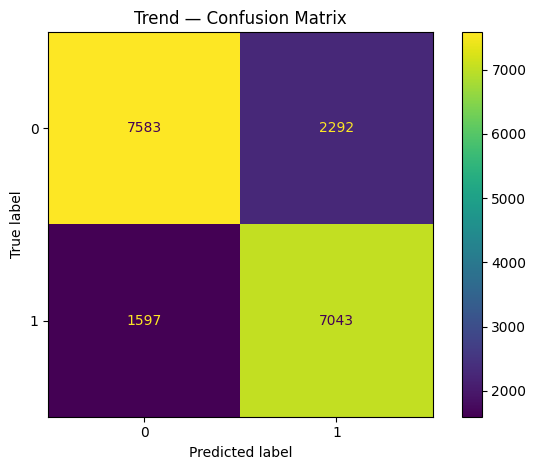

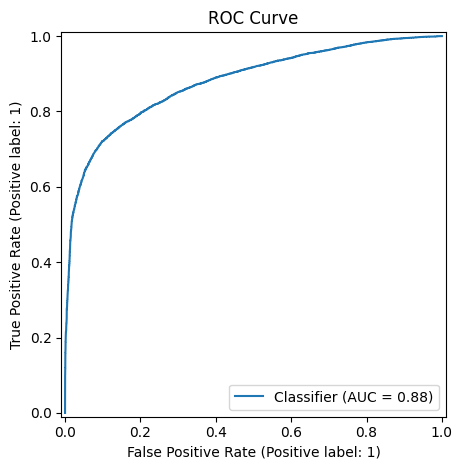

In [11]:
# plot graph
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test, pred, labels=[0,1]))\
    .plot(values_format="d")
plt.title("Trend — Confusion Matrix")
plt.tight_layout(); plt.show()

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve")
plt.tight_layout(); plt.show()


In [12]:
# === H. Quick overfitting check: Train vs Test metrics ===
def eval_split(name, y_true, pred, proba):
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
    acc = accuracy_score(y_true, pred)
    f1  = f1_score(y_true, pred)
    try:
        auc = roc_auc_score(y_true, proba)
    except Exception:
        auc = float('nan')
    print(f"{name:>6} | Acc: {acc:.4f}  F1: {f1:.4f}  AUC: {auc:.4f}  | size={len(y_true)}")

# Training set performance
pred_tr  = pipe.predict(X_train)
proba_tr = pipe.predict_proba(X_train)[:, 1]
eval_split("Train", y_train, pred_tr, proba_tr)

# Test set performance
pred_te  = pipe.predict(X_test)
proba_te = pipe.predict_proba(X_test)[:, 1]
eval_split(" Test", y_test, pred_te, proba_te)

# Class distribution check for extreme imbalance
print("\nLabel balance -> Train:", y_train.value_counts().to_dict(),
      "| Test:", y_test.value_counts().to_dict())

 Train | Acc: 0.7773  F1: 0.7586  AUC: 0.8548  | size=70469
  Test | Acc: 0.7900  F1: 0.7836  AUC: 0.8793  | size=18515

Label balance -> Train: {0: 38602, 1: 31867} | Test: {0: 9875, 1: 8640}


In [ ]:
# ==== To predict data for certain area for next month  ====

def predict_next_month(prefix: str):

    # Get the most recent record for the given postcode prefix
    sub = monthly.loc[monthly["PostcodePrefix"] == prefix].sort_values("YearMonth")
    if sub.empty:
        return {"prefix": prefix, "error": "No data available for this prefix."}
    row = sub.iloc[-1].copy()  # Latest observation (e.g., 2025-11)

    # Calculate the next month's number and update 'month_next' feature
    ym = pd.Period(row["YearMonth"], freq="M")
    target_ym = ym + 6
    row["month_next"] = int(target_ym.month)

    # Prepare the feature vector and make prediction
    feats = num_feats + cat_small + cat_big
    X_new = row[feats].to_frame().T
    pred = int(pipe.predict(X_new)[0])                    # 0 = Down, 1 = Up

    return {
        "Prefix": prefix,
        "Pred target month": str(target_ym),   # Target month to predict (e.g., 2025-12)
        "Model trend": "Up" if pred == 1 else "Down",
    }

def batch_predict_next_month(prefix_list):
    return [predict_next_month(p) for p in prefix_list]

In [26]:
#out = predict_next_month("N6")
#print(out)

results = batch_predict_next_month(["N1", "N6", "W2", "E14"])
for r in results:
    print(r)


{'Prefix': 'N1', 'Pred target month': '2026-02', 'Model trend': 'Up'}
{'Prefix': 'N6', 'Pred target month': '2026-02', 'Model trend': 'Down'}
{'Prefix': 'W2', 'Pred target month': '2026-02', 'Model trend': 'Down'}
{'Prefix': 'E14', 'Pred target month': '2026-02', 'Model trend': 'Down'}
